In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet201
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

In [3]:
seed = 0

In [4]:
train_image_paths_df = pd.read_csv('/kaggle/input/mura-v11/MURA-v1.1/train_image_paths.csv', header=None, names=['path'], dtype=str)
train_labeled_studies_df = pd.read_csv('/kaggle/input/mura-v11/MURA-v1.1/train_labeled_studies.csv', header=None, names=['path', 'label'], dtype=str)
valid_image_paths_df = pd.read_csv('/kaggle/input/mura-v11/MURA-v1.1/valid_image_paths.csv', header=None, names=['path'], dtype=str)
valid_labeled_studies_df = pd.read_csv('/kaggle/input/mura-v11/MURA-v1.1/valid_labeled_studies.csv', header=None, names=['path', 'label'], dtype=str)

In [5]:
train_image_paths_df['parent_path'] = train_image_paths_df['path'].apply(lambda x: re.sub(r'image\d+.png', '', x))
train_labeled_studies_df[['part', 'patient_id', 'study_label']] = list(train_labeled_studies_df['path'].str.split('/').apply(lambda x: x[2:-1]))
train_merge = pd.merge(train_image_paths_df, train_labeled_studies_df, left_on='parent_path', right_on='path')
train_merge.drop(['parent_path', 'path_y', 'patient_id', 'study_label'], axis=1, inplace=True)
train_merge.rename({ 'path_x': 'path' }, axis=1, inplace=True)
label = train_merge.pop('label')
train_merge.insert(train_merge.shape[1], 'label', label)

In [6]:
valid_labeled_studies_df[['part', 'patient_id', 'study_label']] = list(valid_labeled_studies_df['path'].str.split('/').apply(lambda x: x[2:-1]))
valid_image_paths_df['parent_path'] = valid_image_paths_df['path'].apply(lambda x: re.sub(r'image\d+.png', '', x))
valid_merge = pd.merge(valid_image_paths_df, valid_labeled_studies_df, left_on='parent_path', right_on='path')
valid_merge.drop(['parent_path', 'path_y', 'patient_id', 'study_label'], axis=1, inplace=True)
valid_merge.rename({ 'path_x': 'path' }, axis=1, inplace=True)
label = valid_merge.pop('label')
valid_merge.insert(valid_merge.shape[1], 'label', label)

In [7]:
train_merge['path'] = '/kaggle/input/mura-v11/' + train_merge['path']
valid_merge['path'] = '/kaggle/input/mura-v11/' + valid_merge['path']

In [8]:
train_merge.head()

,path,part,label
0,/kaggle/input/mura-v11/MURA-v1.1/train/XR_SHOU...,XR_SHOULDER,1
1,/kaggle/input/mura-v11/MURA-v1.1/train/XR_SHOU...,XR_SHOULDER,1
2,/kaggle/input/mura-v11/MURA-v1.1/train/XR_SHOU...,XR_SHOULDER,1
3,/kaggle/input/mura-v11/MURA-v1.1/train/XR_SHOU...,XR_SHOULDER,1
4,/kaggle/input/mura-v11/MURA-v1.1/train/XR_SHOU...,XR_SHOULDER,1


In [9]:
valid_merge.head()

,path,part,label
0,/kaggle/input/mura-v11/MURA-v1.1/valid/XR_WRIS...,XR_WRIST,1
1,/kaggle/input/mura-v11/MURA-v1.1/valid/XR_WRIS...,XR_WRIST,1
2,/kaggle/input/mura-v11/MURA-v1.1/valid/XR_WRIS...,XR_WRIST,1
3,/kaggle/input/mura-v11/MURA-v1.1/valid/XR_WRIS...,XR_WRIST,1
4,/kaggle/input/mura-v11/MURA-v1.1/valid/XR_WRIS...,XR_WRIST,1


In [10]:
train = train_merge
valid, test = train_test_split(valid_merge, test_size=0.5, random_state=seed)

In [11]:
image_generator = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
)

In [12]:
im_size = 224

In [13]:
train_generator = image_generator.flow_from_dataframe(dataframe=train, x_col='path', y_col='label', class_mode='binary', batch_size=16, shuffle=True, target_size=(im_size, im_size), seed=seed)
valid_generator = image_generator.flow_from_dataframe(dataframe=valid, x_col='path', y_col='label', class_mode='binary', batch_size=16, shuffle=True, target_size=(im_size, im_size), seed=seed)
test_generator = image_generator.flow_from_dataframe(dataframe=test, x_col='path', y_col='label', class_mode='binary', batch_size=16, shuffle=False, target_size=(im_size, im_size), seed=seed)

Found 36808 validated image filenames belonging to 2 classes.
Found 1598 validated image filenames belonging to 2 classes.
Found 1599 validated image filenames belonging to 2 classes.


In [14]:
input_shape=(im_size, im_size, 3)

# DenseNet201

In [15]:
dense201 = DenseNet201(include_top=False, input_shape=input_shape, weights='imagenet', pooling="max", classes=2)

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [16]:
dense201.trainable = False

In [17]:
inputs = tf.keras.layers.Input(shape=input_shape)
x = dense201(inputs, training=False)
x = tf.keras.layers.Dropout(rate=0.2)(x)
output = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)

dense201_model = tf.keras.Model(inputs, output)

In [18]:
dense201_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 1920)           │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,921 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,323,905 (69.90 MB)

 Trainable params: 1,921 (7.50 KB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [19]:
dense201_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[
        tf.keras.metrics.BinaryAccuracy()
    ]
)

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy',
    mode="max",
    patience=5,
    restore_best_weights=True
)

In [21]:
history = dense201_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   2/2301 ━━━━━━━━━━━━━━━━━━━━ 2:21 62ms/step - binary_accuracy: 0.3125 - loss: 2.4391   

I0000 00:00:1714540184.686812     118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2301/2301 ━━━━━━━━━━━━━━━━━━━━ 905s 370ms/step - binary_accuracy: 0.6116 - loss: 0.8216 - val_binary_accuracy: 0.6821 - val_loss: 0.5984
Epoch 2/20
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 565s 245ms/step - binary_accuracy: 0.6611 - loss: 0.6457 - val_binary_accuracy: 0.6452 - val_loss: 0.6511
Epoch 3/20
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 562s 243ms/step - binary_accuracy: 0.6556 - loss: 0.6599 - val_binary_accuracy: 0.6464 - val_loss: 0.6804
Epoch 4/20
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 560s 242ms/step - binary_accuracy: 0.6661 - loss: 0.6381 - val_binary_accuracy: 0.6558 - val_loss: 0.6157
Epoch 5/20
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 563s 244ms/step - binary_accuracy: 0.6629 - loss: 0.6451 - val_binary_accuracy: 0.6746 - val_loss: 0.6048
Epoch 6/20
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 561s 243ms/step - binary_accuracy: 0.6623 - loss: 0.6505 - val_binary_accuracy: 0.6909 - val_loss: 0.6152
Epoch 7/20
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 567s 245ms/step - binary_accuracy: 0.6577 - loss: 0.6530 - val_binary_accuracy: 0

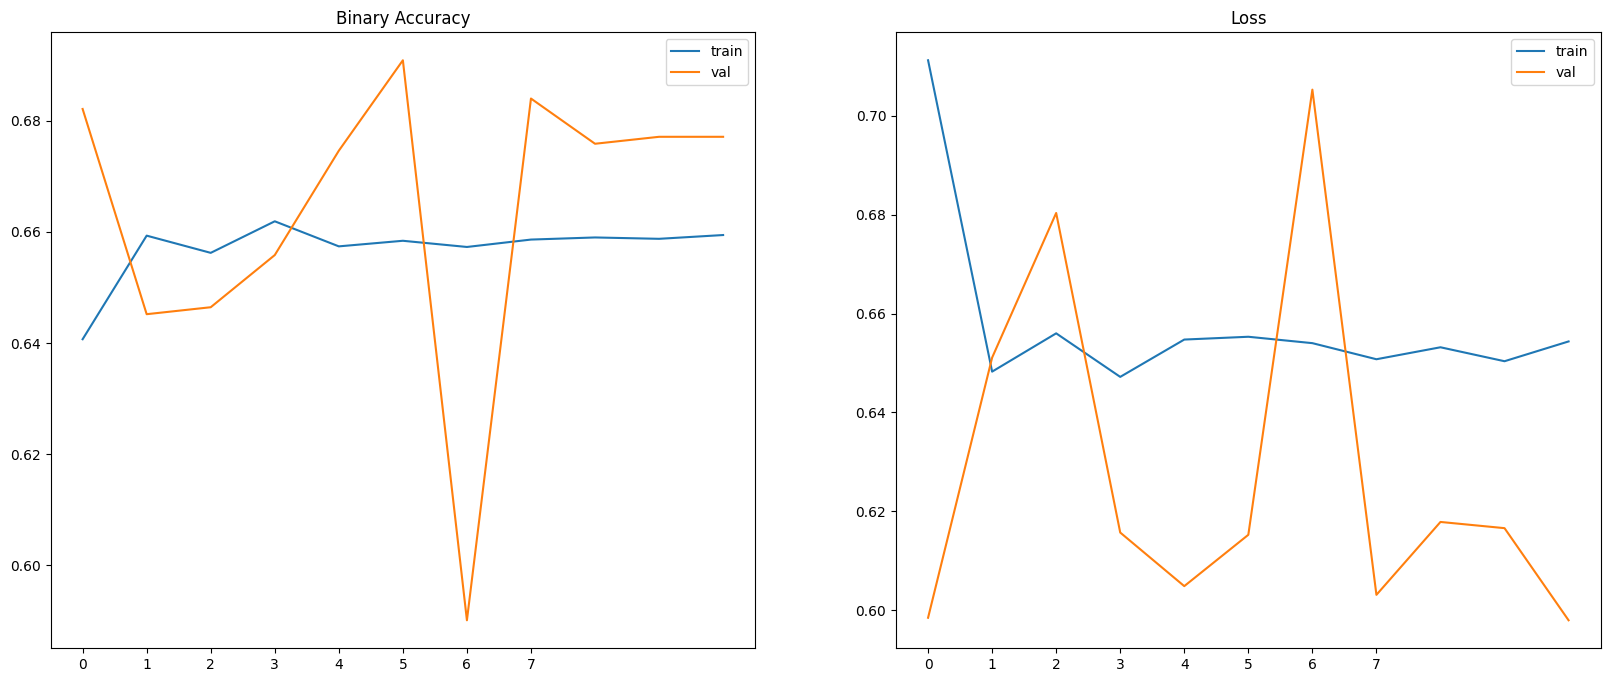

In [35]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.plot(history.history['binary_accuracy'], label='train')
plt.plot(history.history['val_binary_accuracy'], label='val')
plt.xticks(range(0, 8, 1))
plt.title('Binary Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xticks(range(0, 8, 1))
plt.title('Loss')
plt.legend()
plt.show()

In [23]:
evaluate_results = dense201_model.evaluate(test_generator)
evaluate_results

100/100 ━━━━━━━━━━━━━━━━━━━━ 55s 552ms/step - binary_accuracy: 0.6791 - loss: 0.6286


[0.6274277567863464, 0.6666666865348816]

In [24]:
dense201_model.save('dense201_model.keras')

In [25]:
print(classification_report(test_generator.labels, (dense201_model.predict(test_generator) >= 0.5).astype(int)))

100/100 ━━━━━━━━━━━━━━━━━━━━ 57s 396ms/step
              precision    recall  f1-score   support

           0       0.64      0.84      0.72       845
           1       0.72      0.46      0.56       754

    accuracy                           0.66      1599
   macro avg       0.68      0.65      0.64      1599
weighted avg       0.68      0.66      0.65      1599



In [26]:
dense201.trainable = True

In [27]:
dense201_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics=[
        tf.keras.metrics.BinaryAccuracy()
    ]
)

In [28]:
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_binary_accuracy",
    patience=4,
    mode="max",
    factor=0.2,
    min_lr=1e-10,
)

In [29]:
history1 = dense201_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr_on_plateau]
)

Epoch 1/10
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 1099s 354ms/step - binary_accuracy: 0.6678 - loss: 0.7075 - val_binary_accuracy: 0.7547 - val_loss: 0.5367 - learning_rate: 1.0000e-05
Epoch 2/10
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 584s 253ms/step - binary_accuracy: 0.7490 - loss: 0.5641 - val_binary_accuracy: 0.7866 - val_loss: 0.4890 - learning_rate: 1.0000e-05
Epoch 3/10
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 583s 253ms/step - binary_accuracy: 0.7753 - loss: 0.5076 - val_binary_accuracy: 0.7797 - val_loss: 0.4791 - learning_rate: 1.0000e-05
Epoch 4/10
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 588s 255ms/step - binary_accuracy: 0.7927 - loss: 0.4684 - val_binary_accuracy: 0.8060 - val_loss: 0.4745 - learning_rate: 1.0000e-05
Epoch 5/10
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 596s 258ms/step - binary_accuracy: 0.8074 - loss: 0.4360 - val_binary_accuracy: 0.7922 - val_loss: 0.4647 - learning_rate: 1.0000e-05
Epoch 6/10
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 600s 260ms/step - binary_accuracy: 0.8231 - loss: 0.4047 - val_binary_accurac

In [30]:
acc = [*history.history['binary_accuracy'], *history1.history['binary_accuracy']]
val_acc = [*history.history['val_binary_accuracy'], *history1.history['val_binary_accuracy']]
loss = [*history.history['loss'], *history1.history['loss']]
val_loss = [*history.history['val_loss'], *history1.history['val_loss']]

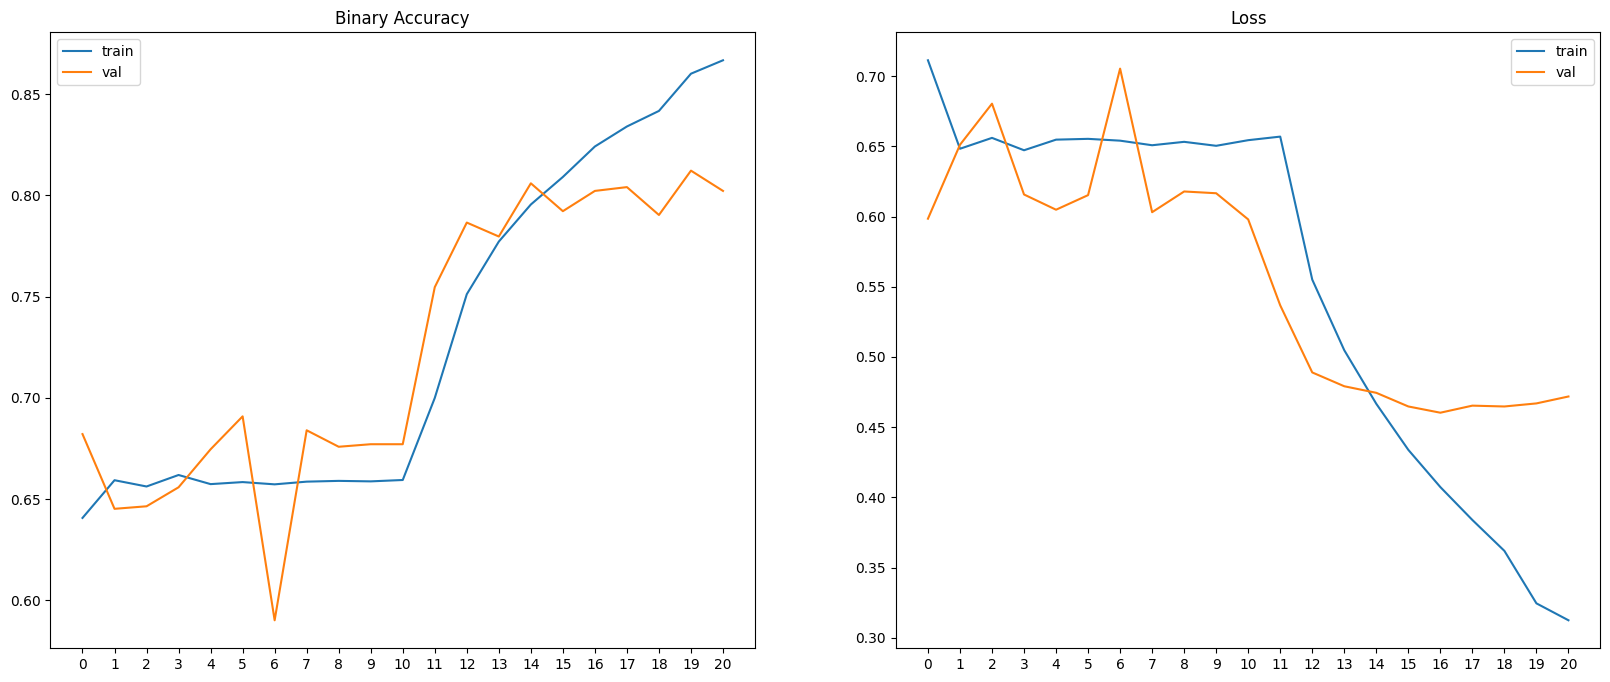

In [36]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.plot(acc, label='train')
plt.plot(val_acc, label='val')
plt.xticks(range(0, len(history.history['binary_accuracy']) + len(history1.history['binary_accuracy']), 1))
plt.title('Binary Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='train')
plt.plot(val_loss, label='val')
plt.xticks(range(0, len(history.history['loss']) + len(history1.history['loss']), 1))
plt.title('Loss')
plt.legend()
plt.show()

In [33]:
dense201_model.save('dense201_model1.keras')

In [34]:
history2 = dense201_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr_on_plateau]
)

Epoch 1/10
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 624s 270ms/step - binary_accuracy: 0.8693 - loss: 0.3102 - val_binary_accuracy: 0.8079 - val_loss: 0.4825 - learning_rate: 2.0000e-06
Epoch 2/10
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 609s 264ms/step - binary_accuracy: 0.8754 - loss: 0.2966 - val_binary_accuracy: 0.8091 - val_loss: 0.4798 - learning_rate: 2.0000e-06
Epoch 3/10
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 608s 263ms/step - binary_accuracy: 0.8768 - loss: 0.2979 - val_binary_accuracy: 0.8060 - val_loss: 0.4759 - learning_rate: 2.0000e-06
Epoch 4/10
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 602s 261ms/step - binary_accuracy: 0.8786 - loss: 0.2891 - val_binary_accuracy: 0.8091 - val_loss: 0.4707 - learning_rate: 2.0000e-06
Epoch 5/10
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 606s 263ms/step - binary_accuracy: 0.8831 - loss: 0.2814 - val_binary_accuracy: 0.8104 - val_loss: 0.4865 - learning_rate: 2.0000e-06


In [44]:
acc = [*history.history['binary_accuracy'], *history1.history['binary_accuracy'], *history2.history['binary_accuracy']]
val_acc = [*history.history['val_binary_accuracy'], *history1.history['val_binary_accuracy'], *history2.history['val_binary_accuracy']]
loss = [*history.history['loss'], *history1.history['loss'], *history2.history['loss']]
val_loss = [*history.history['val_loss'], *history1.history['val_loss'], *history2.history['val_loss']]

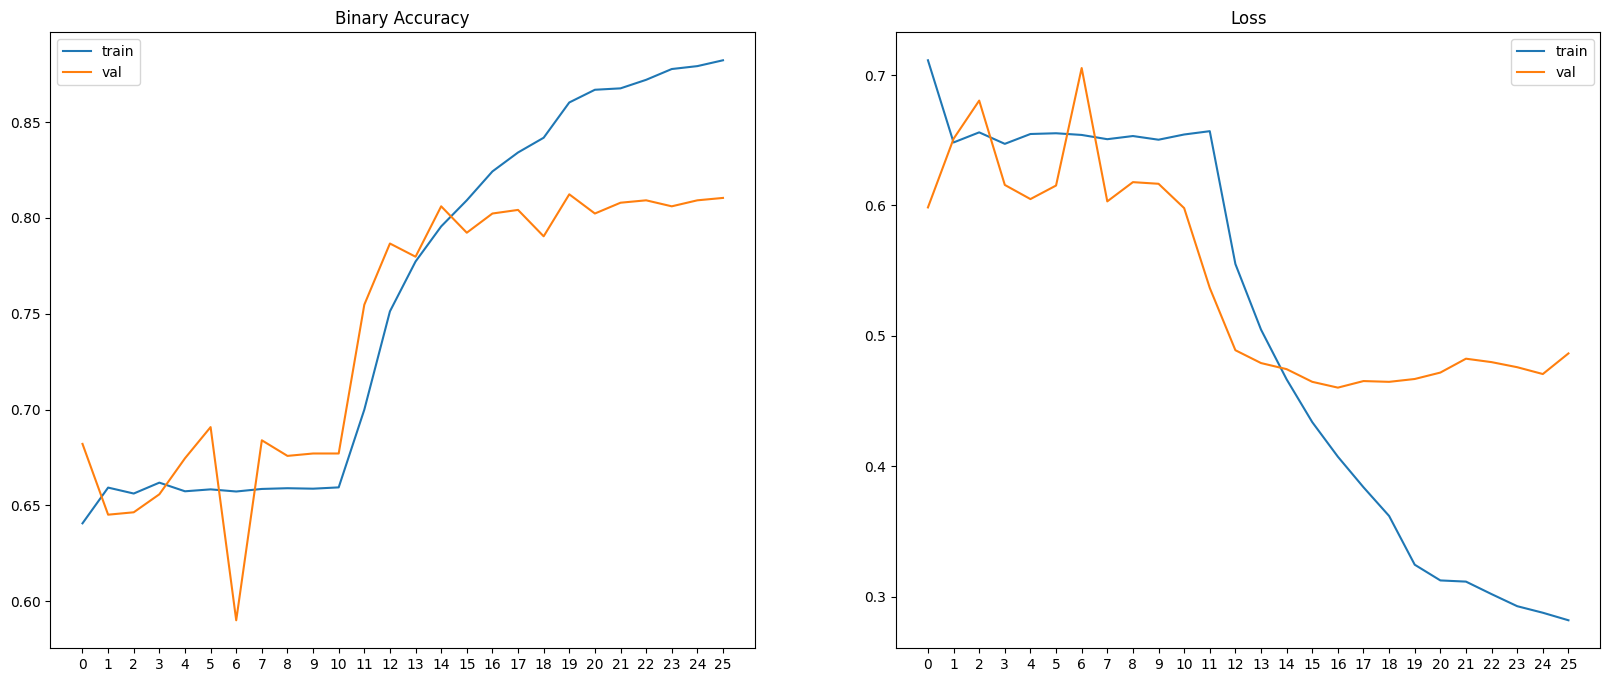

In [45]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.plot(acc, label='train')
plt.plot(val_acc, label='val')
plt.xticks(range(0, len(history.history['binary_accuracy']) + len(history1.history['binary_accuracy']) + len(history2.history['binary_accuracy']), 1))
plt.title('Binary Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='train')
plt.plot(val_loss, label='val')
plt.xticks(range(0, len(history.history['loss']) + len(history1.history['loss']) + len(history2.history['loss']), 1))
plt.title('Loss')
plt.legend()
plt.show()

In [46]:
evaluate_results = dense201_model.evaluate(test_generator)
evaluate_results

100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 345ms/step - binary_accuracy: 0.8097 - loss: 0.5144


[0.5144253969192505, 0.8080049753189087]

In [47]:
dense201_model.save('dense201_model2.keras')

In [48]:
print(classification_report(test_generator.labels, (dense201_model.predict(test_generator) >= 0.5).astype(int)))

100/100 ━━━━━━━━━━━━━━━━━━━━ 53s 375ms/step
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       845
           1       0.85      0.72      0.78       754

    accuracy                           0.81      1599
   macro avg       0.82      0.80      0.81      1599
weighted avg       0.82      0.81      0.81      1599

